In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyocr
from PIL import ImageFont, ImageDraw, Image
import pyocr.builders
import os
import sys
from googletrans import Translator
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from moviepy.editor import *

# Create Sample Movie(45sec)

In [2]:
file_path = "OriginalMovie.mkv"#Original Path
start = 620
end = 620+45
save_path = "sample_cut.mp4"#New Created Path
video = VideoFileClip(file_path).subclip(start, end)#Start Cutting
video.write_videofile(save_path,fps=25) #Write to File

chunk:   0%|                                                                         | 0/993 [00:00<?, ?it/s, now=None]

Moviepy - Building video sample_cut.mp4.
MoviePy - Writing audio in sample_cutTEMP_MPY_wvf_snd.mp3


t:   0%|                                                                            | 0/1125 [00:00<?, ?it/s, now=None]

MoviePy - Done.
Moviepy - Writing video sample_cut.mp4



Moviepy - Done !
Moviepy - video ready sample_cut.mp4


# Define OCR Function

In [2]:
def OCR_read(PIL_data):
    tools = pyocr.get_available_tools()
    if len(tools) == 0:
        print("No OCR tool found")
        sys.exit(1)
    tool = tools[0]
    txt = tool.image_to_string( #define language, options
            PIL_data,
            lang='eng',
            builder=pyocr.builders.TextBuilder(tesseract_layout=6)
            )
    txt1 = txt.replace('\n', " ")#Replace line break with space

    translator = Translator()
    translated = translator.translate(txt1, dest="ja")
    
    return txt1, translated.text

## Chech the OCR operation

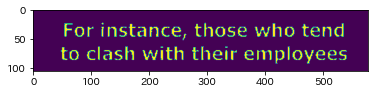

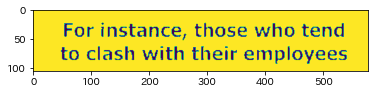

For instance, those who tend to clash with their employees
たとえば、従業員と衝突する傾向がある人


In [5]:
img = cv2.imread("sample.png", 0)
threshold = 230
# Threshold processing
ret, img_thresh = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
plt.imshow(img_thresh)
plt.show()

img_thresh2 = cv2.bitwise_not(img_thresh)
plt.imshow(img_thresh2)
plt.show()

new_image = Image.fromarray(img_thresh2)
en, ja = OCR_read(new_image)
print(en)
print(ja)

# Automatically Adding Japanese subtitles

In [26]:
res_ = []

#read movie
cap = cv2.VideoCapture('SampleMovie.mp4')

#read information
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

#movie for being written
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.m4v', fourcc, fps, (width, height))

#read frame per 3 sec
for num in range(0, int(count), int(fps*3)):

    #extract frame at determined point 
    cap.set(cv2.CAP_PROP_POS_FRAMES, num)
    
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(r"ResultPic\Before_{:03d}.png".format(num), frame)
        #plt.imshow(frame)
        #plt.show()
        frame_subtitles = frame[300:frame.shape[0], 100:600]
        #plt.imshow(frame_subtitles)
        #plt.show()
        frame_subtitles_gray = cv2.cvtColor(frame_subtitles, cv2.COLOR_BGR2GRAY)
        #plt.imshow(frame_subtitles_gray)
        #plt.show()
        threshold = 225
        ret, frame_subtitles_binary = cv2.threshold(frame_subtitles_gray, threshold, 255, cv2.THRESH_BINARY)
        #plt.imshow(frame_subtitles_binary)
        #plt.show()
        frame_subtitles_binary_reverse = cv2.bitwise_not(frame_subtitles_binary)
        #plt.imshow(frame_subtitles_binary_reverse)
        #plt.show()
        frame_subtitles_binary_reverse_image = Image.fromarray(frame_subtitles_binary_reverse)
        #plt.imshow(frame_subtitles_binary_reverse_image)
        #plt.show()
        try:
            en, ja = OCR_read(frame_subtitles_binary_reverse_image)

            #Define where to write Japanese subtitles
            size_ = 14
            start_ = ( (width-size_*len(ja))*0.5 )
            height_ = (300)

            #Wrinting below
            font = ImageFont.truetype("ipag.ttf", size_)
            frame_rgb_ = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image_ = Image.fromarray(frame_rgb_)
            draw_ = ImageDraw.Draw(pil_image_)
            draw_.text((start_, height_), ja, font=font)

            #change cv2 format
            rgb_image_ = cv2.cvtColor(np.array(pil_image_), cv2.COLOR_RGB2BGR)
            out.write(rgb_image_)
            #plt.imshow(rgb_image_)
            #plt.show()
            res_.append([num, en, ja])
            cv2.imwrite(r"ResultPic\After_{:03d}.png".format(num), rgb_image_)
        except TypeError:
            pass
        
cap.release()
out.release()

In [29]:
pd.DataFrame(res_, columns=["Sec", "English", "Japanese"])

,Sec,English,Japanese
0,0,"-You brat, you don't know anything! -That's ri...",-ガキ、何も知らない！-そのとおり！
1,75,"If I'm your successor, will I have",私があなたの後継者なら、
2,150,the authority to appoint new CEOs for our subs...,子会社の新しいCEOを任命する権限はありますか？
3,225,That's great.,それは素晴らしいことです。
4,300,I always thought that a few of the CEOs are un...,私はいつも、CEOの何人かは資格が不足していると思っていました。
5,375,"For instance, those who tend to clash with the...",たとえば、従業員と衝突する傾向がある人
6,450,"For instance, those who tend to clash with the...",たとえば、従業員と衝突する傾向がある人
7,525,or have caused the company great damage due to...,または彼ら自身の無知のために会社に大きな損害を与えました。
8,600,or have caused the company great damage due to...,または彼ら自身の無知のために会社に大きな損害を与えました。
9,675,We should fire such CEGs without any hesitation.,そのようなCEGをためらうことなく発射する必要があります。
